In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
import math as m
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error


In [2]:
#We choose to convert the .csv file to .xls format and use pandas to parse it:
data = pd.ExcelFile("COVID19_Data_Spain.xls")
sheetX = data.parse(0) 
date = sheetX['Date']
infected = sheetX['Infected']
deaths = sheetX['Deaths']
recovered = sheetX['Recovered']
dt = np.linspace(1,len(infected),len(infected))
a = (1/2.3)
ro = (1/5.2)

#### Improving the SIR model: Lockdown 

In [3]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


In [4]:
#population pyramid database of Spain in 2019 until 95 years old
data = pd.ExcelFile('piramide_esp.xls')
piramide = data.parse(0) 
age = piramide['Age']
ind = piramide['Individuals']

pyramid_df = pd.DataFrame(data=ind,index=age)

In [5]:
#we are going to compute some weights 
df = pyramid_df.cumsum()
columns = df.columns[:]
df = pd.merge(_out_df, pyramid_df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], columns]
df.loc[df.index[0], columns] = _first
df[columns] = df[columns].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Individuals
0,0,2,nursery,3,0,0,0.068092
1,3,5,nursery school,4,0,1,0.078674
2,6,10,elementary school,5,0,1,0.083213
3,11,13,middle school,5,0,1,0.083213
4,14,18,high school,6,0,1,0.077570
5,19,25,university/work,3,3,1,0.085717
6,26,35,work,0,6,1,0.116654
7,36,45,work,0,5,1,0.127553
8,46,55,work,0,5,1,0.109117
9,56,65,work,0,5,1,0.080120


In [6]:
def go_out(column, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[column]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [7]:
eg_out_df = go_out('Individuals')
eg_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,3,0,0,0.068092
1,3,5,nursery school,4,0,1,0.078674
2,6,10,elementary school,5,0,1,0.083213
3,11,13,middle school,5,0,1,0.083213
4,14,18,high school,6,0,1,0.077570
5,19,25,university/work,3,3,1,0.085717
6,26,35,work,0,6,1,0.116654
7,36,45,work,0,5,1,0.127553
8,46,55,work,0,5,1,0.109117
9,56,65,work,0,5,1,0.080120


#### g_s before lockdown

In [8]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.777342909774071

#### g_s after lockdown
- Schools are closed
- 50% of people works remotely
- People will go out one day for other reasons instead of going to school/office.

In [9]:
df = eg_out_df.copy()
df["School"] = 0
df["Office"] *= 0.5
df["Others"] = 0
df.loc[df["School"] + df["Office"] == 0, "Others"] += 1

eg_out_df_after = df.copy()
eg_out_df_after

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,0,0.0,1,0.068092
1,3,5,nursery school,0,0.0,1,0.078674
2,6,10,elementary school,0,0.0,1,0.083213
3,11,13,middle school,0,0.0,1,0.083213
4,14,18,high school,0,0.0,1,0.077570
5,19,25,university/work,0,1.5,0,0.085717
6,26,35,work,0,3.0,0,0.116654
7,36,45,work,0,2.5,0,0.127553
8,46,55,work,0,2.5,0,0.109117
9,56,65,work,0,2.5,0,0.080120


In [10]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

1.7513520435496965

#### Simulation:
- Before day 43: SIQR model.
- After day 43: SIQR model with lockdown factor (g_s). 

In [29]:
def SIR_conf(I_cond,dt,r,q):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0-q*I0
    drdt = (1/2.3)*I0+q*I0
    return dsdt,didt,drdt

def evolution_SIR_conf(t,q,r):
    return odeint(SIR_conf,[2671886,1,0],t,args = (r,q))[:,1]

Nota: Primero he probado de estimar r y q cogiendo los valores experimentales hasta el dia de Lockdown... No me sale bien :(

In [40]:
day_lockdown = 43
#r_before = 2.2811369474341536e-07
S0 = 30e6

params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt[:day_lockdown],infected[:day_lockdown],(1e-3,1e-3)) 
q_value_SIR_conf = params_SIR_conf


print('The value for q is equal to:',q_value_SIR_conf[0])
print('The value for r is equal to:',q_value_SIR_conf[1])

q_value = q_value_SIR_conf[0]
r_value = q_value_SIR_conf[1]

The value for q is equal to: 5.046944091707332
The value for r is equal to: 0.026044344433888447


C:\Users\Celia\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [42]:
r_after = r_value * (gs_after / gs_before)
r_after / r_value

0.303141439049216

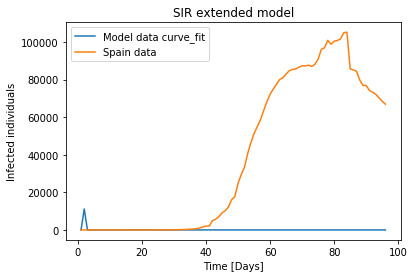

In [43]:
#Results

SIR_conf_results = odeint(SIR_conf,[2671886,1,0],dt[:day_lockdown],args = (r_value,q_value))
S_conf, I_conf, R_conf = SIR_conf_results.T

SIR_lockdown = odeint(SIR_conf,[S_conf[-1], I_conf[-1], R_conf[-1]],dt[day_lockdown:],args = (r_after, q_value))
S_lock, I_lock, R_lock = SIR_lockdown.T

I_conf=list(I_conf)
I_conf.extend(I_lock)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data curve_fit')
plt.plot(dt,infected,label='Spain data')


plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()


Nota: Como no me ha salido bien, he cogido los valores que ya habiamos calculado. r se habia estimado con el Scenario 1, todos los datos experimentales, y q se habia estimado en el Scenario 2 con los datos a partir del dia 43... No me convence... Quizas podriamos mantener r y solo estimar q cogiendo los datos hasta el dia 43? Que opinas?

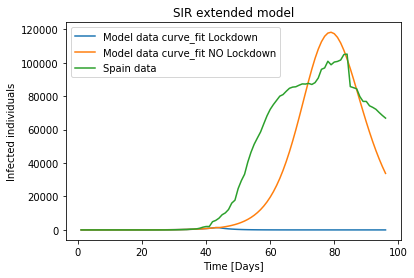

In [28]:
#Results
q_value=0.002627970480552251  
r_value=2.2811369474341536e-07

SIR_conf_results = odeint(SIR_conf,[2671886,1,0],dt[:day_lockdown],args = (r_value,q_value))
S_conf, I_conf, R_conf = SIR_conf_results.T

r_after = r_value * (gs_after / gs_before)
SIR_lockdown = odeint(SIR_conf,[S_conf[-1], I_conf[-1], R_conf[-1]],dt[day_lockdown:],args = (r_after, q_value))
S_lock, I_lock, R_lock = SIR_lockdown.T

I_conf_lockdown=list(I_conf)
I_conf_lockdown.extend(I_lock)

SIR_no_lockdown = odeint(SIR_conf,[S_conf[-1], I_conf[-1], R_conf[-1]],dt[day_lockdown:],args = (r_value, q_value))
S_no_lock, I_no_lock, R_no_lock = SIR_no_lockdown.T
I_conf_no_lock=list(I_conf)
I_conf_no_lock.extend(I_no_lock)

plt.figure(1)
plt.plot(dt,I_conf_lockdown,label='Model data curve_fit Lockdown')
plt.plot(dt,I_conf_no_lock,label='Model data curve_fit NO Lockdown')
plt.plot(dt,infected,label='Spain data')


plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()